# Hyperspectral Images (HSI) Processing

> *Machine Learning and Computational Statistics*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

<p style='text-align: justify;'>
<b>Hyperspectral Images (HSIs):</b> An HSI depicts a specific scene at several $(L)$ narrow continuous spectral bands (actually, they visualize the reflectance of the depicted scene in various spectral bands). It can be represented by a $MxNxL$ three dimensional cube, where the first two dimensions correspond to the spatial information, while the third dimension corresponds to the spectral information. Thus, the $(i,j)$ pixel in such an image, $i=1,...,M$, $j=1,...,N$, is represented by an $L$-dimensional vector (constituted by the corresponding spectral bands), called the <b><i>spectral signature</b></i> of the pixel.
</p>

![Spectral Signature](./images/spectral_signature.png)

<p style='text-align: justify;'>
In several remote sensing applications, the HSIs (taken from satellites) that depict specific scenes of the earth surface at a specific spatial resolution (that is, a single pixel may represent an area from $3x3m^{2}$ to $100x100m^{2}$ or more). That is, each pixel is likely to depict more than one materials depicted in the corresponding area of the scene. Such pixels are called <b><i>mixed pixels</b></i> and they are the vast majority of the pixels in the image. On the other hand, there are (usually) a few pixels that depict a single material. These are called <b><i>pure pixels</b></i>.
</p>

![Spectral Signature Ground](./images/mixed_pure_pixels.png)

**Processing in HSIs:** The usual processing procedures in HSIs follow two main directions, namely, the ***spectral unmixing*** and the ***classification***.


<ul>
    <li><p style='text-align: justify;'>
(a) <b>Spectral Unmixing (SU):</b> The problem here is stated as follows: Assume that a set of $m$ spectral signatures corresponding to the pure pixels in the HSI under study is given. For a given pixel in the image, the aim is to determine the percentage (<b><i>abundance</b></i>) to which each pure material contributes in its formation. It is clear, that SU provides <b><i>sub-pixel information</b></i> for a given pixel. Speaking in mathematical terms, let:
    </p></li>  
<ul>
    <li><p style='text-align: justify;'>
        1. $y$ be the (column $L$-dimensional) spectral signature of the pixel under study
    </p></li>
    <li><p style='text-align: justify;'>
        2. $x_1,...,x_m$ be the spectral signatures (column $L$-dimensional vectors) of the pure pixels in the image (each one corresponding to a pure material met in the image)
    </p></li>
    <li><p style='text-align: justify;'>
        3. $θ$, the $m$-dimensional <b><i>abundance vector</b></i> of the pixel (its $q$-th coordinate corresponds to the percentage to which the $q$-th pure pixel contributes to the formation of the pixel under study).
    </p></li>
</ul>
</ul>

<p style='text-align: justify;'>
Adopting the <b><i>linear spectral unmixing hypothesis</b></i>, the above quantities are related as follows, $y=Xθ+η$, where $η$ is an $L$-dimensional i.i.d., zero mean Gaussian noise vector. Note that, physically, the <b>entries</b> of $θ$ should be <b>non negative</b> and (ideally) they should <b>sum to one</b>.
</p>

<ul>
    <li><p style='text-align: justify;'>
(b) <b>(Supervised) Classification:</b> In this case, the problem is stated as follows: Assume that all pixels in the HSI under study are known to belong to one out of $m$ <b><i>known classes</b></i>. Given a specific pixel, the aim is to determine the most suitable class to assign it.
    </p></li>
</ul>

## *Table of Contents*

- [*1. Introduction*](#introduction)
    - [*1.1. Libraries*](#libraries)
    - [*1.2. Data*](#data)
- [*2. Part 1 - Spectral Unmixing*](#part_1)
    - [*2.1. Least Squares*](#ls)
    - [*2.2. Least Squares imposing the sum-to-one constraint*](#ls_sto)
    - [*2.3. Least Squares imposing the non-negativity constraint on the entries of θ*](#ls_nn)
    - [*2.4. Least Squares imposing the non-negativity and the sum-to-one constraint on the entries of θ*](#ls_nn_sto)
    - [*2.5. Lasso, i.e., impose sparsity on θ via L1 norm minimization*](#lasso)
    - [*2.6. Compare Results*](#compare_1)
- [*3. Part 2 - Classification*](#part_2)
    - [*3.1. Naive Bayes Classifier*](#nb)
    - [*3.2. Minimum Euclidean Distance Classifier*](#med)
    - [*3.3. K-Nearest Neighbors Classifier*](#knn)
    - [*3.4. Bayesian Classifier*](#bc)
    - [*3.5. Compare Results*](#compare_2)
- [*4. Conclusion*](#conclusion)

---

## Introduction <a class='anchor' id='introduction'></a>

### *Libraries* <a class='anchor' id='libraries'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.io as sio
import scipy.optimize
from scipy.optimize import nnls 
from scipy.optimize import minimize
from sklearn.linear_model import Lasso

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

### *Data* <a class='anchor' id='data'></a>

- The data refers to the so called **"Salinas"** HSI, which depicts an area of the Salinas valley in California, USA
- It is a 220x120 spatial resolution HSI and consists of 204 spectral bands (from 0.2μm – 2.4μm) and its spatial resolution is 3.7m
- That is, the HSI is a 220x204 cube
- The data that will be used are in the files ***Salinas_cube.mat*** (the Salinas hypercube) and ***Salinas_gt.mat*** (the class label for each pixel)

## Part 1 <a class='anchor' id='part_1'></a>

## Spectral Unmixing

The **"Salinas"** HSI includes **7 endmembers**, each one corresponding to a certain material (cultivation in our case), as described in the following table:

| Endmember | Material |
| --------- | -------- |
| 1 | Grapes |
| 2 | Broccoli |
| 3 | Fallow 1 |
| 4 | Fallow 2 |
| 5 | Fallow 3 |
| 6 | Stubble |
| 7 | Celery |

<p style='text-align: justify;'>
The aim here is to perform <b>unmixing</b> on <b>each one</b> of the <b>pixels</b> in the image <b>with nonzero label</b>, with respect to the <b>7 endmembers</b>, using the following five different spectral unmixing methods:
</p>

- (a) **Least squares**
- (b) **Least squares** imposing the *sum-to-one* constraint
- (c) **Least squares** imposing the *non-negativity* constraint on the entries of ***θ***
- (d) **Least squares** imposing both the *non-negativity* and the *sum-to-one* constraint on the entries of ***θ***
- (e) **LASSO**, i.e., impose sparsity on ***θ*** via L1 norm minimization

For **each method:**
   - Derive the corresponding **7 abundance maps** (one for each endmember / material)
   - Compute the **reconstruction error** (for each, non-zero class label, pixel $y_i$ compute the quantity $\|y_i - Xθ_i\|^2$ and take the average over those pixels)
   
##### *Read the data for Part 1 - Spectral Unmixing*

In [2]:
# Salinas HSI: 220x120x204
Salinas = sio.loadmat('./data/Salinas_cube.mat')
HSI = Salinas['salinas_cube']

# Endmember's matrix: 204x7
ends = sio.loadmat('./data/Salinas_endmembers.mat') 
endmembers = ends['salinas_endmembers']

# Ground truth
ground_truth = sio.loadmat('./data/Salinas_gt.mat')
labels = ground_truth['salinas_gt']

##### *Plot the 7 endmembers spectral signatures of Salinas HSI*

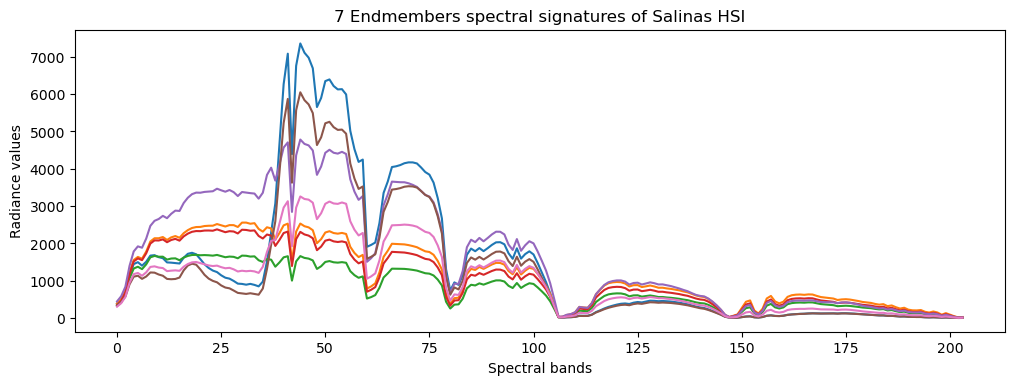

In [3]:
plt.figure(figsize=(12,4), dpi=100, facecolor='white')
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

### *(a) Least Squares* <a class='anchor' id='ls'></a>

<p style='text-align: justify;'>
The method of <b>least lquares (LS)</b> is a standard approach in <i>regression analysis</i> to approximate the solution of <i>overdetermined systems</i> (sets of equations in which there are more equations than unknowns) by minimizing the sum of the squares of the residuals (a residual being the difference between an observed value and the fitted value provided by a model) made in the results of each individual equation. - <a href="https://en.wikipedia.org/wiki/Least_squares"><i>Wikipedia</i></a>
</p>

##### *Create and stack an array of ones in the endmembers matrix in order to calculate the $θ_0$*

In [4]:
# create an array of ones
ones = np.ones((204,1))

# stack the array of ones in the endmembers matrix
X = np.hstack((ones, endmembers))

##### *Create function to calculate theta estimates*

- $θ = (X^T X)^{-1} (X^T y)$

In [5]:
def get_thetas(X,Y):
    theta = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y))
    return theta

##### *Calculate theta estimates*

In [6]:
# counter
counter_idx = 0

# initialise tuple to store theta vectors for every pixel
thetas_a = np.empty((220*120,8))

# loop through 220
for i in range(HSI.shape[0]):
    
    # loop through 120
    for j in range(HSI.shape[1]):
        
        # if non-zero class label
        if labels[i,j] != 0:
            
            # set Y
            Y = HSI[i,j,:]
            
            # calculate thetas
            thetas = get_thetas(X,Y)
            
            # store thetas
            thetas_a[counter_idx] = thetas
            
        counter_idx += 1

##### *Define function to derive the abundance maps (one for each endmember)*

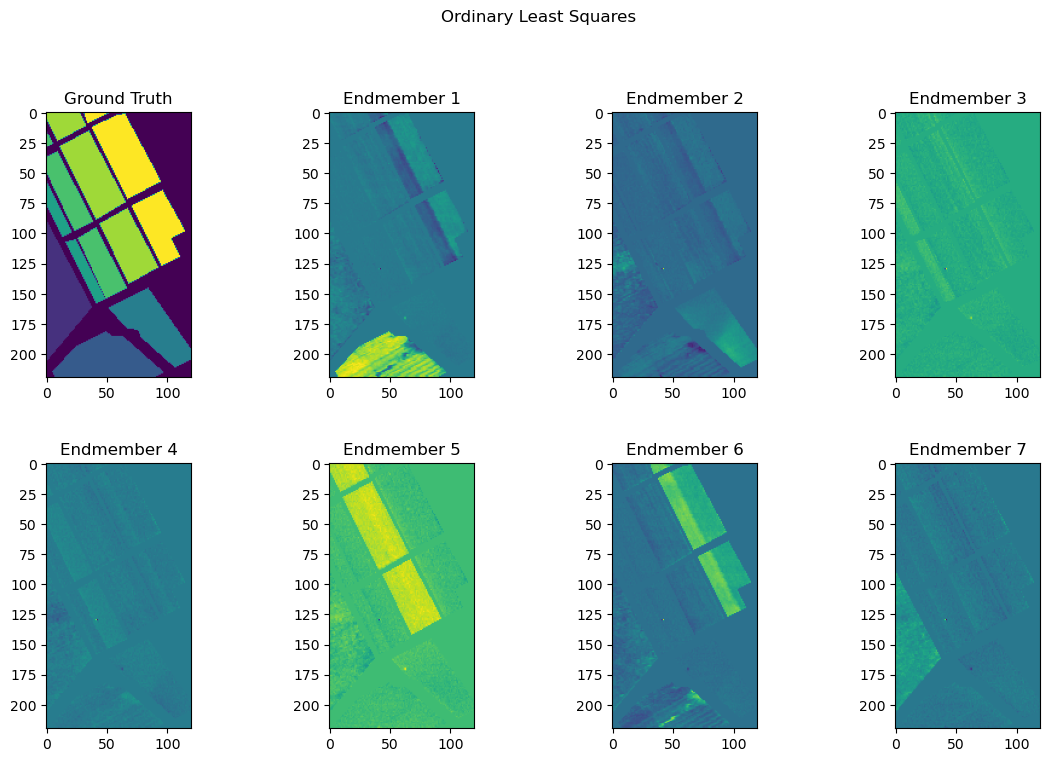

In [7]:
def plot_abundance_maps(thetas, ls_method):
    # create the figure
    fig, ax = plt.subplots(2,4,figsize=(12,8),dpi=100,facecolor='white')
    # loop through thetas
    for i in range(8):
        # plot ground truth
        if i == 0:
            ax[0,i].imshow(ground_truth['salinas_gt'].reshape(220,120))
            ax[0,i].set_title('Ground Truth')
        # plot endmembers 1-3
        elif i <= 3:
            ax[0,i].imshow(thetas[:,i].reshape(220,120))
            ax[0,i].set_title(f'Endmember {i}')
        # plot endmembers 4-7
        else:
            ax[1,i-4].imshow(thetas[:,i].reshape(220,120))
            ax[1,i-4].set_title(f'Endmember {i}')
    plt.suptitle(ls_method)
    plt.tight_layout(pad=3)
    plt.show()
    return

# execute function
_ = plot_abundance_maps(thetas_a, 'Ordinary Least Squares')

##### *Compute the reconstruction error*

- $\|y_i - Xθ_i\|^{2}$

In [8]:
# initialise list to store the errors
rec_error_a = []

# counter to iterate over pixels
start_i = 0

# loop through 220
for i in range(HSI.shape[0]):
    
    # loop through 120
    for j in range(HSI.shape[1]):
        
        # if non-zero class label
        if labels[i,j] != 0:
            
            # set Y
            Y = HSI[i,j,:]
            
            # calculate the reconstruction error
            error = np.linalg.norm(Y - np.dot(X, thetas_a[start_i]))**2
            rec_error_a.append(error)
            
        start_i += 1
            
mean_error_a = np.mean(rec_error_a)
            
print(f'LS - Reconstruction Error: {mean_error_a}')

LS - Reconstruction Error: 32963.718880806475


<p style='text-align: justify;'>
The methods followed below are known as <b><i>Regularized Least Squares (RLS)</i></b>. RLS is a family of methods for solving the <i>least squares</i> problem while using <i>regularization</i> to further constrain the resulting solution. RLS is used for <i>two main reasons</i>. The <b><i>first reason</i></b> comes up when the number of variables in the linear system exceeds the number of observations. In such settings, the <i>ordinary least squares</i> problem is <i>ill-posed</i> and is therefore impossible to fit because the associated optimization problem has infinitely many solutions. RLS allows the introduction of further constraints that uniquely determine the solution. The <b><i>second reason</i></b> that RLS is used occurs when the number of variables does not exceed the number of observations, but the learned model suffers from poor <i>generalization</i>. RLS can be used in such cases to improve the generalizability of the model by constraining it at training time. This constraint can either force the solution to be "sparse" or to reflect other prior knowledge about the problem such as information about correlations between features. - <a href="https://en.wikipedia.org/wiki/Regularized_least_squares"><i>Wikipedia</i></a>
</p>

### *(b) Least Squares imposing the sum-to-one constraint* <a class='anchor' id='ls_sto'></a>

<p style='text-align: justify;'>
The <b>least squares imposing the sum-to-one constraint</b> is a type of <i>regularized least squares (RLS)</i> problem where the regression coefficients should sum to one. That is, given a matrix $X$ and a (column) vector of <i>response variables</i> $y$, the goal is to find $argmin_θ\|Xθ-y\|_2^2$ subject to $Σ_iθ_i=1$. Here $Σ_iθ_i=1$ means that the sum of the components of the vector $θ$ should sum to one, and $\|·\|_2$ denotes the <i>Euclidean norm</i>.
</p>

##### *Create function to calculate the Euclidean distance*

- $\sqrt{Σ_{i}^{n}(y_{i}-x_{i})^{2}}$

In [9]:
def euclidean_distance(X, A, Y):
    distance = np.linalg.norm(A.dot(X) - Y)
    return distance

##### *Calculate theta estimates*

In [10]:
# counter
counter_idx = 0

# initialise tuple to store theta vectors for every pixel
thetas_b = np.empty((220*120,8))

# define the parameters for the sum-to-one constraint
cons = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# loop through 220
for i in range(HSI.shape[0]):
    
    # loop through 120
    for j in range(HSI.shape[1]):
        
        # if non-zero class label
        if labels[i,j] != 0:
            
            # for each pixel we minimize the least squares subjected to sum-to-one constraint
            opt = minimize(euclidean_distance, np.zeros((1,8)), args=(X, HSI[i,j,:]), method='SLSQP', constraints=cons)
            
            # return the solution as an array
            thetas = opt.x
            
            # store thetas
            thetas_b[counter_idx] = thetas

        counter_idx += 1

##### *Derive the abundance maps (one for each endmember)*

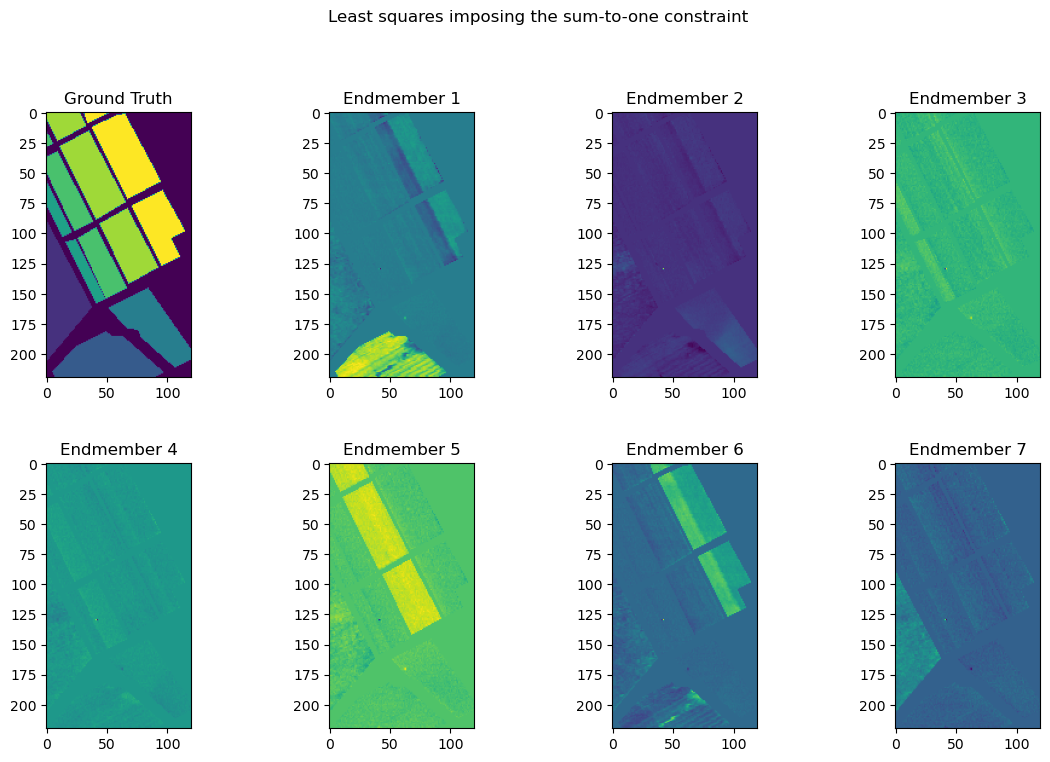

In [11]:
# execute function
_ = plot_abundance_maps(thetas_b, 'Least squares imposing the sum-to-one constraint')

##### *Compute the reconstruction error*

- $\|y_i - Xθ_i\|^{2}$

In [12]:
# initialise list to store the errors
rec_error_b = []

# counter to iterate over pixels
start_i = 0

# loop through 220
for i in range(HSI.shape[0]):
    
    # loop through 120
    for j in range(HSI.shape[1]):
        
        # if non-zero class label
        if labels[i,j] != 0:
            
            # set Y
            Y = HSI[i,j,:]
            
            # calculate the reconstruction error
            error = np.linalg.norm(Y - np.dot(X, thetas_b[start_i]))**2
            rec_error_b.append(error)
            
        start_i += 1

mean_error_b = np.mean(rec_error_b)
            
print(f'LS (imposing the sum-to-one constraint) - Reconstruction Error: {mean_error_b}')

LS (imposing the sum-to-one constraint) - Reconstruction Error: 35066.384230992466


### *(c) Least Squares imposing the non-negativity constraint on the entries of θ* <a class='anchor' id='ls_nn'></a>

<p style='text-align: justify;'>
In <i>mathematical optimization</i>, the problem of <b>non-negative least squares (NNLS)</b> is a type of <i>regularized least squares (RLS)</i> problem where the coefficients are not allowed to become negative. That is, given a matrix $X$ and a (column) vector of <i>response variables</i> $y$, the goal is to find $argmin_θ\|Xθ-y\|_{2}^{2}$ subject to $θ>=0$. Here $θ>=0$ means that each component of the vector $θ$ should be non-negative, and $\|·\|_{2}$ denotes the <i>Euclidean norm</i>. - <a href="https://en.wikipedia.org/wiki/Non-negative_least_squares"><i>Wikipedia</i></a>
</p>

##### *Calculate theta estimates*

In [13]:
# counter
counter_idx = 0

# initialise tuple to store theta vectors for every pixel
thetas_c = np.empty((220*120,8))

# loop through 220
for i in range(HSI.shape[0]):
    
    # loop through 120
    for j in range(HSI.shape[1]):
        
        # if non-zero class label
        if labels[i,j] != 0:
            
            # set Y
            Y = HSI[i,j,:]
            
            # calculate thetas
            thetas = nnls(X,Y)[0]
            
            # store thetas
            thetas_c[counter_idx] = thetas
            
        counter_idx += 1

##### *Derive the abundance maps (one for each endmember)*

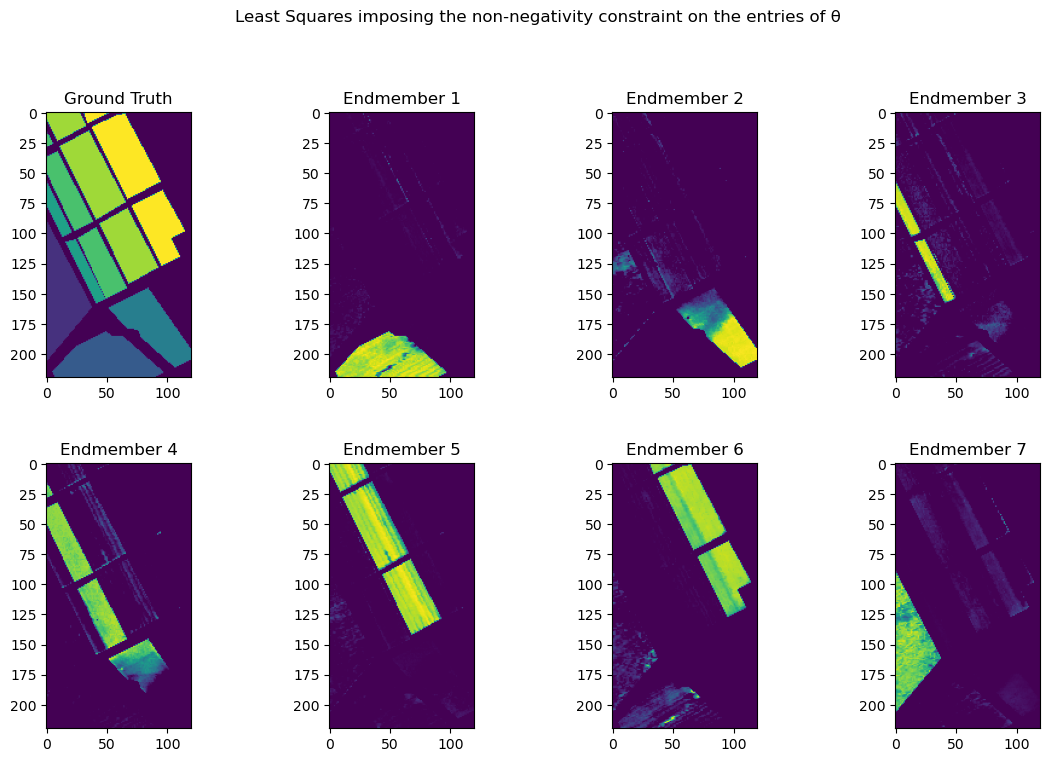

In [14]:
# execute function
_ = plot_abundance_maps(thetas_c, 'Least Squares imposing the non-negativity constraint on the entries of θ')

##### *Compute the reconstruction error*

- $\|y_i - Xθ_i\|^{2}$

In [15]:
# initialise list to store the errors
rec_error_c = []

# counter to iterate over pixels
start_i = 0

# loop through 220
for i in range(HSI.shape[0]):
    
    # loop through 120
    for j in range(HSI.shape[1]):
        
        # if non-zero class label
        if labels[i,j] != 0:
            
            # set Y
            Y = HSI[i,j,:]
            
            # calculate the reconstruction error
            error = np.linalg.norm(Y - np.dot(X, thetas_c[start_i]))**2
            rec_error_c.append(error)
            
        start_i += 1
            
mean_error_c = np.mean(rec_error_c)
            
print(f'LS (imposing the sum-to-one constraint) - Reconstruction Error: {mean_error_c}')

LS (imposing the sum-to-one constraint) - Reconstruction Error: 144636.5584131113


### *(d) Least Squares imposing both the non-negativity and the sum-to-one constraint on the entries of θ* <a class='anchor' id='ls_nn_sto'></a>

Regularized Least Squares (RLS) method which combines ***both*** the *non-negativity* and the *sum-to-one* constraint on the entries of $θ$.

##### *Calculate theta estimates*

In [16]:
# counter
counter_idx = 0

# initialise tuple to store theta vectors for every pixel
thetas_d = np.empty((220*120,8))

# loop through 220
for i in range(HSI.shape[0]):
    
    # loop through 120
    for j in range(HSI.shape[1]):
        
        # if non-zero class label
        if labels[i,j] != 0:
            
            # non-negativity constraint
            xnn = nnls(X, HSI[i,j])[0]
            
            # for each pixel we minimize the least squares subjected to sum-to-one constraint
            opt = minimize(euclidean_distance, xnn, args=(X, HSI[i,j,:]), method='SLSQP', constraints=cons)
            
            # return the solution as an array
            thetas = opt.x
            
            # store theta
            thetas_d[counter_idx] = thetas
            
        counter_idx += 1

##### *Derive the abundance maps (one for each endmember)*

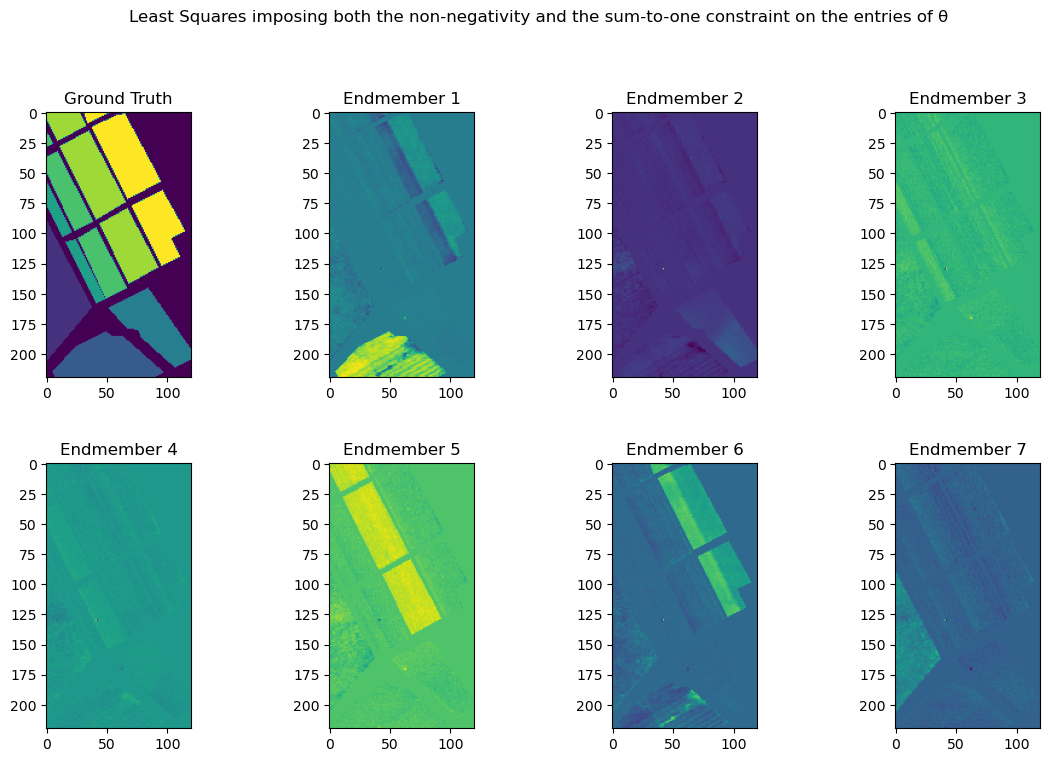

In [17]:
# execute function
_ = plot_abundance_maps(thetas_d, 'Least Squares imposing both the non-negativity and the sum-to-one constraint on the entries of θ')

##### *Compute the reconstruction error*

- $\|y_i - Xθ_i\|^{2}$

In [18]:
# initialise list to store the errors
rec_error_d = []

# counter to iterate over pixels
start_i = 0

# loop through 220
for i in range(HSI.shape[0]):
    
    # loop through 120
    for j in range(HSI.shape[1]):
        
        # if non-zero class label
        if labels[i,j] != 0:
            
            # set Y
            Y = HSI[i,j,:]
            
            # calculate the reconstruction error
            error = np.linalg.norm(Y - np.dot(X, thetas_d[start_i]))**2
            rec_error_d.append(error)
            
        start_i += 1
            
mean_error_d = np.mean(rec_error_d)
            
print(f'LS (imposing both the non-negativity and the sum-to-one constraint) - Reconstruction Error: {mean_error_d}')

LS (imposing both the non-negativity and the sum-to-one constraint) - Reconstruction Error: 35066.3842371441


### *(e) LASSO, i.e., impose sparsity on θ via L1 norm minimization* <a class='anchor' id='lasso'></a>

<p style='text-align: justify;'>
    An alternative <i>regularized</i> version of least squares is <b>LASSO</b> (least absolute shrinkage and selection operator), which uses the constraint that $\|β\|^{2}$, the <i>L2 norm</i> of the parameter vector, is not greater than a given value. In <i>Bayesian</i> context, this is equivalent to placing a zero-mean <i>Laplace prior distribution</i> on the parameter vector. - <a href="https://en.wikipedia.org/wiki/Least_squares#Lasso_method"><i>Wikipedia</i></a>
</p>

##### *Calculate theta estimates (LASSO coefficients)*

In [19]:
# counter
counter_idx = 0

# initialise tuple to store theta vectors for every pixel
thetas_e = np.empty((220*120,8))

# initialise the lasso regression model
model = Lasso(alpha=0.01, max_iter=100000, positive=True, random_state=1)

# loop through 220
for i in range(HSI.shape[0]):
    
    # loop through 120
    for j in range(HSI.shape[1]):
        
        # if non-zero class label
        if labels[i,j] != 0:
            
            # fit the model
            model.fit(X, HSI[i,j,:])
            
            # store thetas (= coefficients)
            thetas_e[counter_idx] = model.coef_
            
        counter_idx += 1

##### *Derive the abundance maps (one for each endmember)*

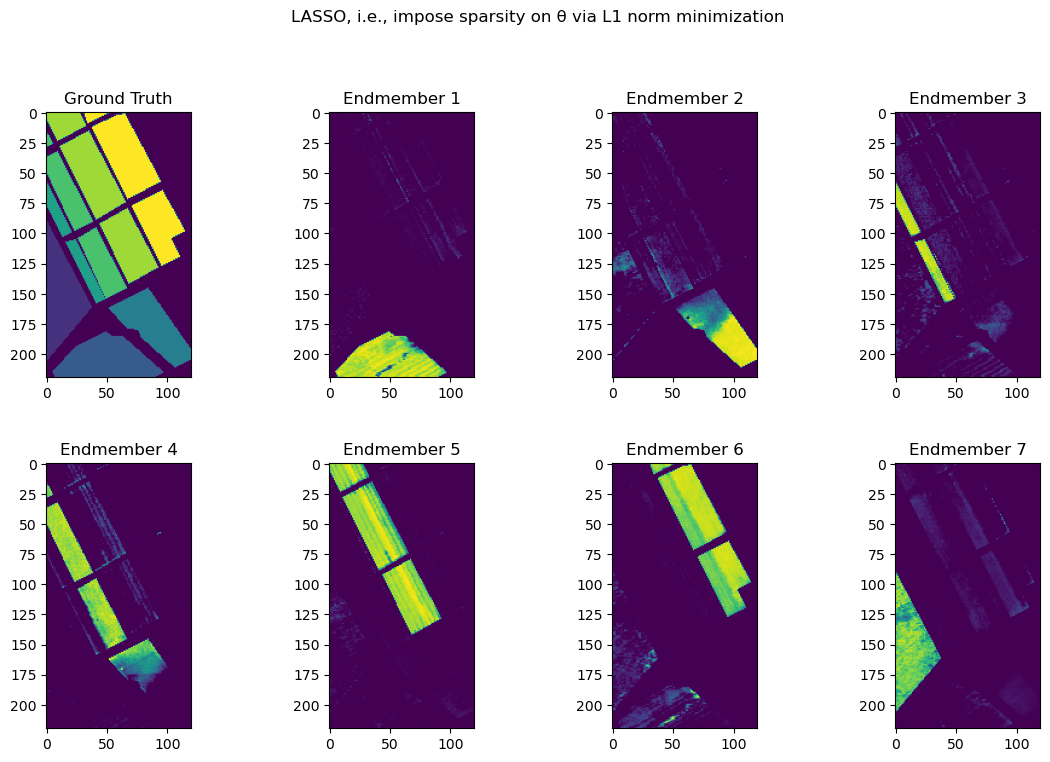

In [20]:
# execute function
_ = plot_abundance_maps(thetas_e, 'LASSO, i.e., impose sparsity on θ via L1 norm minimization')

##### *Compute the reconstruction error*

- $\|y_i - Xθ_i\|^{2}$

In [21]:
# initialise list to store the errors
rec_error_e = []

# counter to iterate over pixels
start_i = 0

# loop through 220
for i in range(HSI.shape[0]):
    
    # loop through 120
    for j in range(HSI.shape[1]):
        
        # if non-zero class label
        if labels[i,j] != 0:
            
            # set Y
            Y = HSI[i,j,:]
            
            # calculate the reconstruction error
            error = np.linalg.norm(Y - np.dot(X, thetas_e[start_i]))**2
            rec_error_e.append(error)
            
        start_i += 1
            
mean_error_e = np.mean(rec_error_e)
            
print(f'Lasso - Reconstruction Error: {mean_error_e}')

Lasso - Reconstruction Error: 195024.70423631553


### *Compare Results* <a class='anchor' id='compare_1'></a>

##### *Create a dataframe with all the least squares methods and their errors to compare the results*

In [22]:
# list with the reconstruction errors
errors = [mean_error_a, mean_error_b, mean_error_c, mean_error_d, mean_error_e]

# list with all the least squares methods used
methods = ['LS', 'LS (sum-to-one)', 'LS (non-negative)', 'LS (non-negative and sum-to-one)', 'Lasso']

# put everything in a dataframe
df = pd.DataFrame(data=errors, index=methods, columns=['error'])

##### *Plot the reconstruction errors*

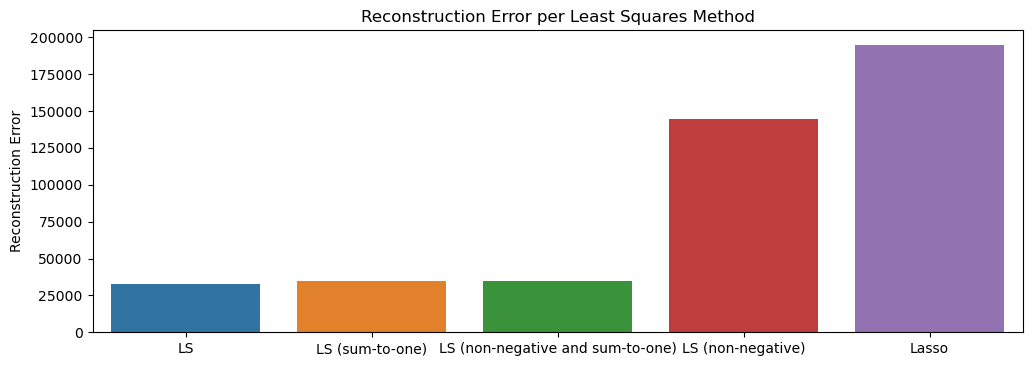

In [23]:
plt.figure(figsize=(12,4), dpi=100, facecolor='white')
sns.barplot(x=df.index, y=df.error, data=df, order=df.sort_values('error').index)
plt.xlabel(None)
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error per Least Squares Method')
plt.show()

##### *LS Abundance Maps vs Ground Truth vs Lasso Abundance Maps*

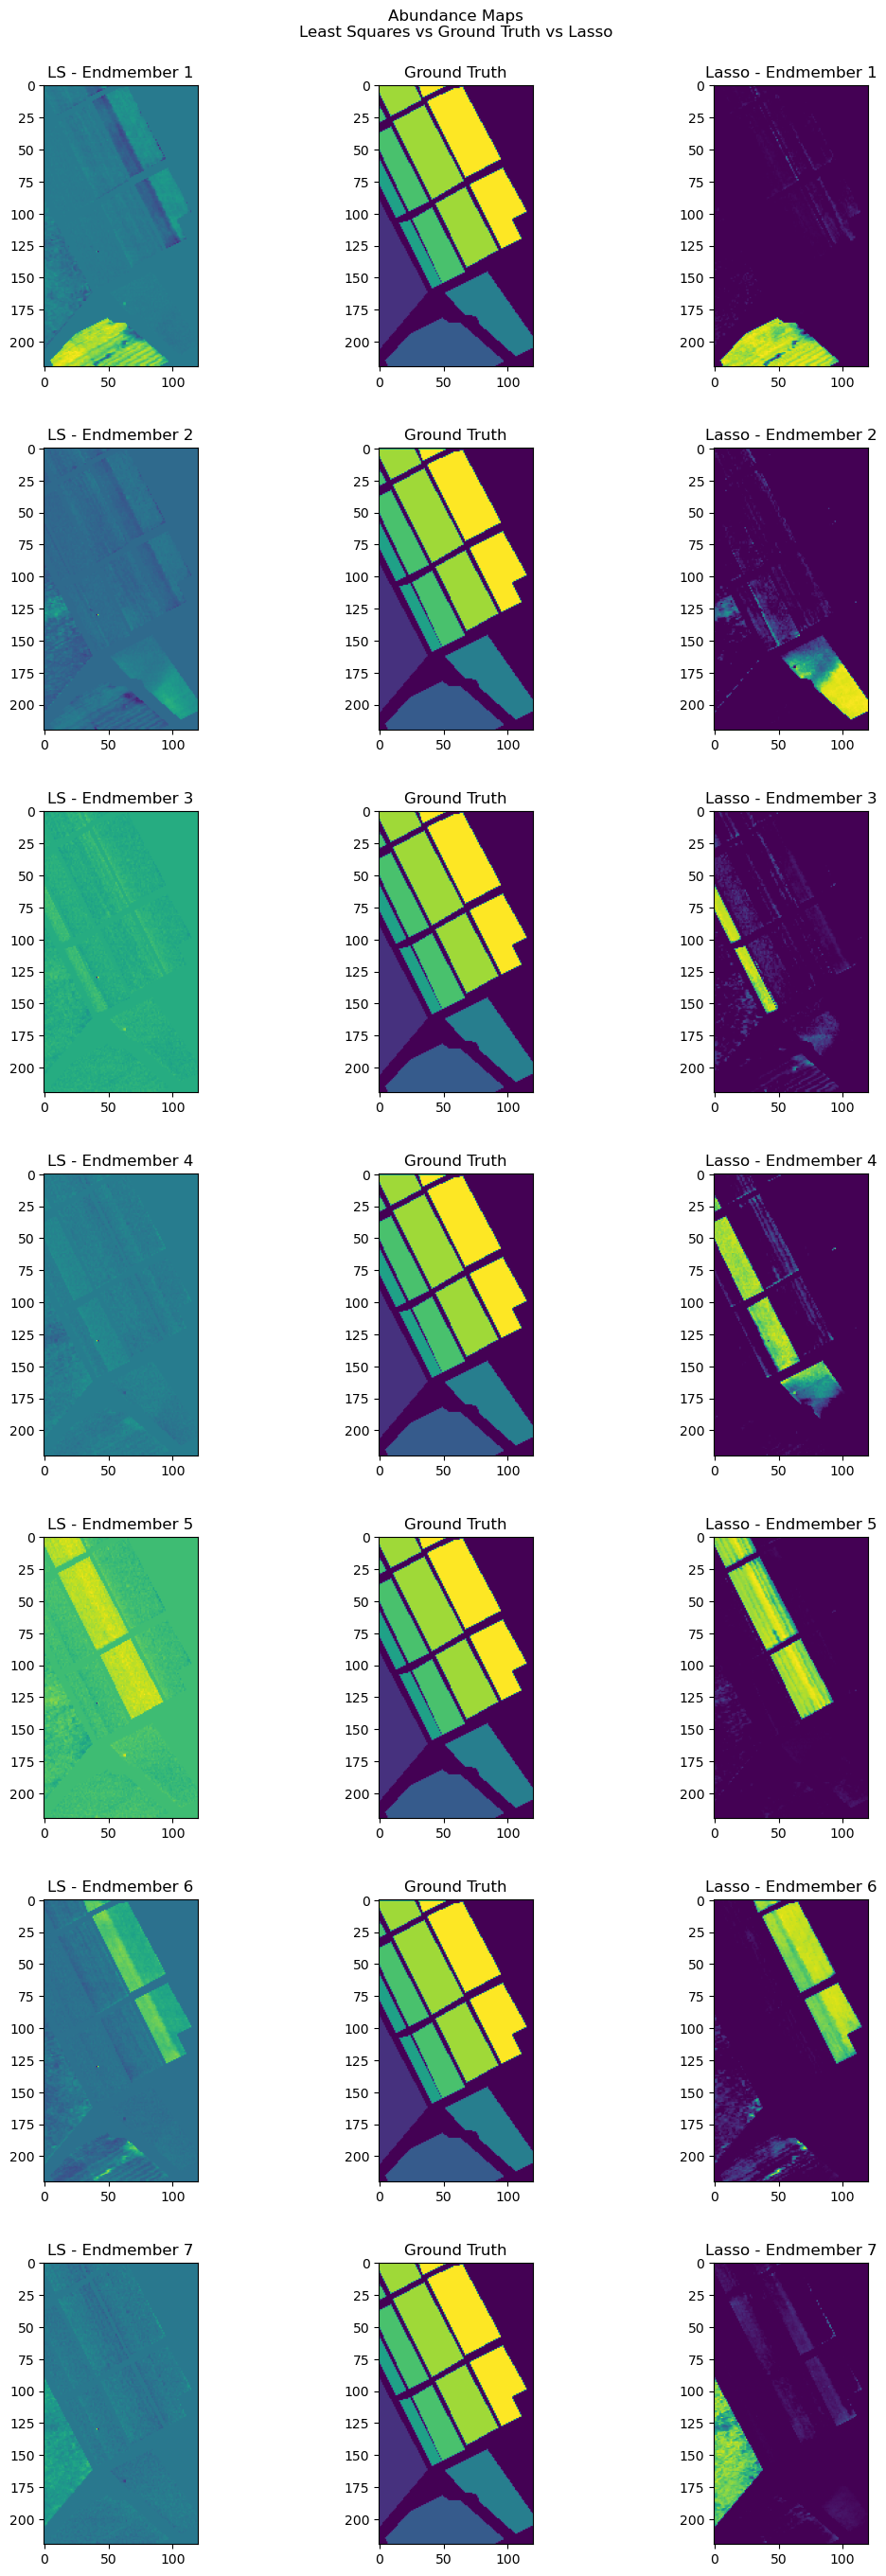

In [24]:
# create the figure
fig, ax = plt.subplots(7,3,figsize=(12,28),dpi=100,facecolor='white')

for i in range(1,8):
    # plot the LS
    ax[i-1,0].imshow(thetas_a[:,i].reshape(220,120))
    ax[i-1,0].set_title(f'LS - Endmember {i}')
    # plot the Ground Truth
    ax[i-1,1].imshow(ground_truth['salinas_gt'].reshape(220,120))
    ax[i-1,1].set_title('Ground Truth')
    # plot the Lasso
    ax[i-1,2].imshow(thetas_e[:,i].reshape(220,120))
    ax[i-1,2].set_title(f'Lasso - Endmember {i}')
    
plt.suptitle('Abundance Maps\nLeast Squares vs Ground Truth vs Lasso')
plt.tight_layout(pad=3)
plt.show()

##### *Comments*

<p style='text-align: justify;'>In general, the optimal spectral unmixing method should result in abundance maps where each of them depicts only the pixels corresponding to the respective class. In our case, by comparing the results obtained from the different methods, we can clearly observe that there are two methods that perform significantly better than the others. In particular, Non-Negative LS and LASSO managed to separate the material to a great extent. On the other hand, when we consider the reconstruction error of each method, we have a completely different story. OLS yields the lowest reconstruction error, while both Non-Negative LS and LASSO have by far the worst performance.</p>

<p style='text-align: justify;'>This strange behavior, though, might have an explanation. LS methods with inequality constraints and regularizations are much more difficult to solve as a minimization problem, than those with equality or no constraints at all. Therefore, this could lead us to the conclusion that the reconstruction error might not be the right source of truth when it comes to measure the spectral unmixing performance, and that the abundance maps obtained from constrained LS methods return a better representation of the ground truth.</p>

---

## Part 2 <a class='anchor' id='part_2'></a>

## Classification

<p style='text-align: justify;'>
    In this case, we <b>consider</b> also the image <b>pixels</b> with <b>non-zero class labels</b>. The task is to assign each one of them to the most appropriate class, among the <b><i>7 known classes (endmembers)</i></b>. To this end, four classifiers will be used:
</p>

- The *Naive Bayes* classifier
- The *Minimum Euclidean Distance* classifier
- The *K-Nearest Neighbor* classifier
- The *Bayesian Classifier*

<p style='text-align: justify;'>
For each one of them the <b><i>same training</i></b>, <b><i>test</i></b> and <b><i>operational</i></b> sets will be used. Note that, <b><i>in practice</i></b>, we have at our disposal a set of points which we split into the training and the test set. The operational set mentioned above corresponds to data presented to the classifiers <b><i>after</i></b> their training and evaluation, that is, during their operational mode.
</p>

For **each classifier:**
   - (a) Train it based on the training set performing a 10-fold cross validation
   - (b) Report the estimated validation error as the mean of the ten resulting error values
   - (c) Compute, also, the associated standard deviation
   - (d) After that, use the whole training set to train the classifier and evaluate their performance on the test set as follows:
       - Compute the **confusion matrix**
       - Compute the **success rate** of the classifier (sum of the diagonal elements of the confusion matrix and divide by the sum of all elements of the matrix)

##### *Read the data for Part 2 - Classification*

In [25]:
# Salinas labels - Train, Test and Operational set
Salinas_labels = sio.loadmat('./data/classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

##### *Plot the datasets*

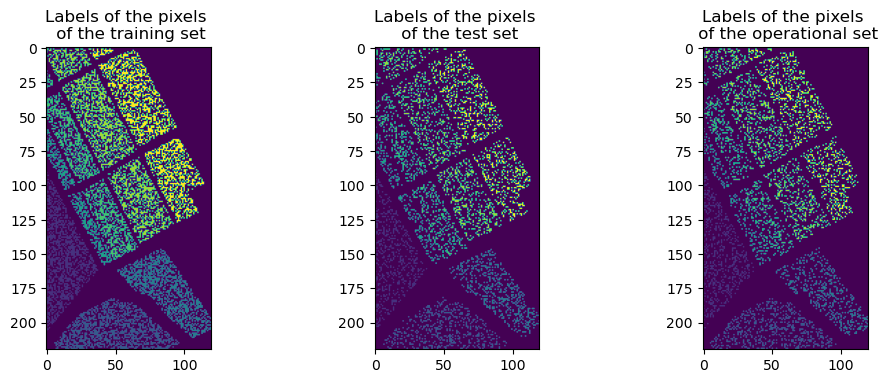

In [26]:
# create the figure
fig, ax = plt.subplots(1,3,figsize=(12,4), dpi=100)
# labels - train set
ax[0].imshow(Training_Set)
ax[0].set_title('Labels of the pixels \n of the training set')
# labels - test set
ax[1].imshow(Test_Set)
ax[1].set_title('Labels of the pixels \n of the test set')
# labels - operational set
ax[2].imshow(Operational_Set)
ax[2].set_title('Labels of the pixels \n of the operational set')
plt.show()

##### *Define `x_train` - `y_train`, `x_test` - `y_test`, `x_op` - `y_op`*

In [27]:
# create empty lists to store train, test, operational set
x_train, x_test, x_op, y_train, y_test, y_op = [], [], [], [], [], []

# loop through 220
for i in range(HSI.shape[0]):
    
    # loop through 120
    for j in range(HSI.shape[1]):
        
        # if non-zero value
        if Training_Set[i,j] != 0:
            
            # x train / y train
            x_train.append(HSI[i,j,:])
            y_train.append(Training_Set[i,j])
        
        # if non-zero value
        if Test_Set[i,j] != 0:
            
            # x test / y test
            x_test.append(HSI[i,j,:])
            y_test.append(Test_Set[i,j])
        
        # if non-zero value
        if Operational_Set[i,j] != 0:
            
            # x operational / y operational
            x_op.append(HSI[i,j,:])
            y_op.append(Operational_Set[i,j])

##### *Initialise a 10-fold stratified cross validation instance*

In [28]:
# initialise stratified cv instance
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

### *Naive Bayes* <a class='anchor' id='nb'></a>

##### *Calculate the mean validation error and the standard deviation*

In [29]:
# select model
model = GaussianNB()

# calculate the score for the 10-fold stratified cross validation
scores = cross_validate(model, x_train, y_train, scoring=['accuracy'], cv=cv)

# calculate the error
error_nb = 1 - scores['test_accuracy'].mean()

# calculate the standard deviation
stdev_nb = np.std(scores['test_accuracy'])

print(f'        Mean Error: {error_nb}')
print(f'Standard Deviation: {stdev_nb}')

        Mean Error: 0.018428691446099377
Standard Deviation: 0.002854997185625547


##### *Compute the confusion matrix*

In [30]:
# fit the model
model.fit(x_train, y_train)

# make predictions
preds_nb = model.predict(x_test)

# display the confusion matrix
confusion_matrix(y_test, preds_nb)

array([[545,   0,   0,   0,   0,   0,   3],
       [  5, 512,   0,   0,   0,   0,   0],
       [  0,   0, 470,   0,  42,   0,   0],
       [  0,   0,   0, 210,   4,   0,   0],
       [  0,   0,  12,   4, 547,   0,   0],
       [  1,   0,   2,   0,   0, 995,   0],
       [  6,   0,   0,   0,   0,   0, 874]])

##### *Compute the success rate*

In [31]:
# compute the success rate
success_rate_nb = np.trace(confusion_matrix(y_test, preds_nb)) / np.sum(confusion_matrix(y_test, preds_nb))

# display the result
print(f'Naive Bayes - Success Rate: {success_rate_nb}')

Naive Bayes - Success Rate: 0.9813327032136105


### *Minimum Euclidean Distance Classifier* <a class='anchor' id='med'></a>

##### *Import the functions needed in order to implement the Minimum Euclidean Distance classifier*

In [32]:
from functions.med_classifier_master import calculate_the_mean_color_value_of_each_class
from functions.med_classifier_master import calculate_the_minimum_euclidean_distance_and_predict_the_class
from functions.med_classifier_master import calculate_the_mean_error_of_the_minimum_euclidean_distance_predictions

##### *Calculate the mean validation error and the standard deviation*

In [33]:
# convert the train and test sets to array
x_train_array, y_train_array = np.asarray(x_train), np.asarray(y_train)
x_test_array, y_test_array = np.asarray(x_test), np.asarray(y_test)

# create a list to store the errors
minimum_euclidean_distance_errors = []

# loop through the 10 folds of the stratified cross validation
for train_index, test_index in cv.split(x_train_array, y_train_array):
    
    # define x_train and y_train on i-th iteration
    x_train_iteration, y_train_iteration = x_train_array[train_index], y_train_array[train_index]
    
    # define x_test and y_test on i-th iteration
    x_test_iteration, y_test_iteration = x_train_array[test_index], y_train_array[test_index]
    
    # calculate the mean (color) value of each class on i-th iteration
    class_means = calculate_the_mean_color_value_of_each_class(x_train_iteration, y_train_iteration)
    
    # calculate the minimum euclidean distances between the class means and the data point (color) values
    # and predict the class for each data point on i-th iteration
    preds_med = calculate_the_minimum_euclidean_distance_and_predict_the_class(x_test_iteration, class_means)
    
    # calculate the mean error of the predictions on i-th iteration
    error = calculate_the_mean_error_of_the_minimum_euclidean_distance_predictions(y_test_iteration, preds_med)
    
    minimum_euclidean_distance_errors.append(error)

# calculate the error
error_med = np.mean(minimum_euclidean_distance_errors)

# calculate the standard deviation
stdev_med = np.std(minimum_euclidean_distance_errors)

print(f'        Mean Error: {error_med}')
print(f'Standard Deviation: {stdev_med}')

        Mean Error: 0.04441848716510226
Standard Deviation: 0.004937573646853818


##### *Compute the confusion matrix*

In [34]:
confusion_matrix(y_test_array, calculate_the_minimum_euclidean_distance_and_predict_the_class(x_test_array, calculate_the_mean_color_value_of_each_class(x_train_array, y_train_array)))

array([[536,   0,   4,   0,   1,   0,   7],
       [  2, 484,   0,   0,   0,   0,  31],
       [  0,   0, 417,   0,  95,   0,   0],
       [  0,   0,   0, 212,   2,   0,   0],
       [  0,   0,  16,   4, 543,   0,   0],
       [  0,   0,   6,   0,   0, 992,   0],
       [  5,   0,   0,   0,   0,   0, 875]])

##### *Compute the success rate*

In [35]:
# compute success rate
success_rate_med = np.trace(confusion_matrix(y_test_array, calculate_the_minimum_euclidean_distance_and_predict_the_class(x_test_array, calculate_the_mean_color_value_of_each_class(x_train_array, y_train_array)))) / np.sum(confusion_matrix(y_test_array, calculate_the_minimum_euclidean_distance_and_predict_the_class(x_test_array, calculate_the_mean_color_value_of_each_class(x_train_array, y_train_array))))

# display the result
print(f'Minimum Euclidean Distance - Success Rate: {success_rate_med}')

Minimum Euclidean Distance - Success Rate: 0.9591209829867675


### *KNN* <a class='anchor' id='knn'></a>

##### *Calculate the mean validation error and the standard deviation*

In [36]:
# select model
model = KNeighborsClassifier(n_neighbors=5)

# calculate the score for the 10-fold stratified cross validation
scores = cross_validate(model, x_train, y_train, scoring=['accuracy'], cv=cv)

# calculate the error
error_knn = 1 - scores['test_accuracy'].mean()

# calculate the standard deviation
stdev_knn = np.std(scores['test_accuracy'])

print(f'        Mean Error: {error_knn}')
print(f'Standard Deviation: {stdev_knn}')

        Mean Error: 0.006024182136367906
Standard Deviation: 0.0022679260983909464


##### *Compute the confusion matrix*

In [37]:
# fit the model
model.fit(x_train, y_train)

# make predictions
preds_knn = model.predict(x_test)

# display the confusion matrix
confusion_matrix(y_test, preds_knn)

array([[547,   0,   0,   0,   0,   0,   1],
       [  0, 516,   0,   0,   0,   0,   1],
       [  0,   0, 510,   0,   2,   0,   0],
       [  0,   0,   0, 213,   1,   0,   0],
       [  0,   0,   8,   1, 552,   2,   0],
       [  0,   0,   0,   0,   0, 998,   0],
       [  0,   1,   0,   0,   0,   0, 879]])

##### *Compute the success rate*

In [38]:
# compute the success rate
success_rate_knn = np.trace(confusion_matrix(y_test, preds_knn)) / np.sum(confusion_matrix(y_test, preds_knn))

# display the result
print(f'KNN - Success Rate: {success_rate_knn}')

KNN - Success Rate: 0.9959829867674859


### *Bayesian Classifier* <a class='anchor' id='bc'></a>

##### *Calculate the mean validation error and the standard deviation*

In [39]:
# select model
model = QuadraticDiscriminantAnalysis()

# calculate the score for the 10-fold stratified cross validation
scores = cross_validate(model, x_train, y_train, scoring=['accuracy'], cv=cv)

# calculate the error
error_bc = 1 - scores['test_accuracy'].mean()

# calculate the standard deviation
stdev_bc = np.std(scores['test_accuracy'])

print(f'        Mean Error: {error_bc}')
print(f'Standard Deviation: {stdev_bc}')

        Mean Error: 0.031186833798052427
Standard Deviation: 0.005468388228593418


##### *Compute the confusion matrix*

In [40]:
# fit the model
model.fit(x_train, y_train)

# make predictions
preds_bc = model.predict(x_test)

# display the confusion matrix
confusion_matrix(y_test, preds_bc)

array([[548,   0,   0,   0,   0,   0,   0],
       [  0, 517,   0,   0,   0,   0,   0],
       [  0,   0, 512,   0,   0,   0,   0],
       [  0,   0,   0, 125,  89,   0,   0],
       [  0,   0,   3,   0, 558,   2,   0],
       [  0,   0,   0,   0,   0, 998,   0],
       [  0,   0,   0,   0,   0,   0, 880]])

##### *Compute the success rate*

In [41]:
# compute the success rate
success_rate_bc = np.trace(confusion_matrix(y_test, preds_bc)) / np.sum(confusion_matrix(y_test, preds_bc))

# display the result
print(f'Bayesian Classifier - Success Rate: {success_rate_bc}')

Bayesian Classifier - Success Rate: 0.9777882797731569


### *Compare Results* <a class='anchor' id='compare_2'></a>

##### *Create a dataframe with all the classifiers and their success errors to compare the results*

In [42]:
# lists with the success rates and the reconstruction errors
reconstruction_errors = [error_nb, error_med, error_knn, error_bc]
success_rates = [success_rate_nb, success_rate_med, success_rate_knn, success_rate_bc]
data = list(zip(reconstruction_errors,success_rates))

# list with all the classifiers
classifiers = ['Naive Bayes Classifier','Minimum Euclidean Distance Classifier','KNN Classifier','Bayesian Classifer']

# put everything in a dataframe
df = pd.DataFrame(data=data, index=classifiers, columns=['error', 'success_rate'])

##### *Plot the errors and the success rates*

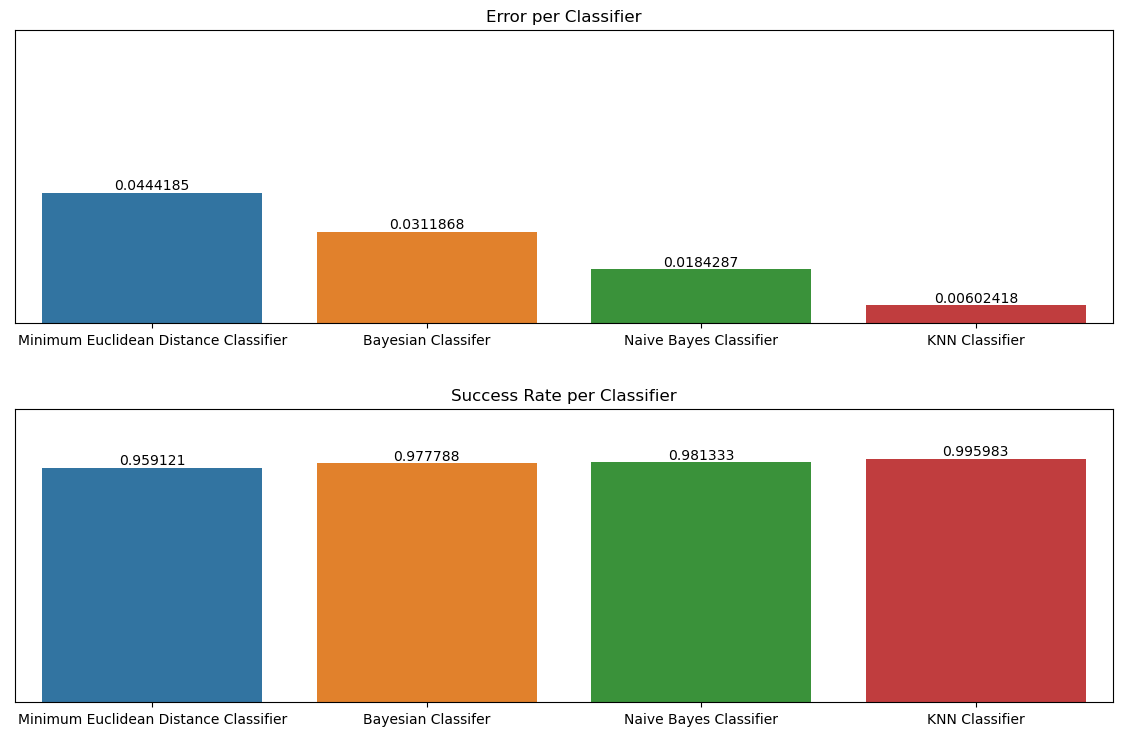

In [43]:
fig, ax = plt.subplots(2,1,figsize=(12,8),dpi=100,facecolor='white')

# plot errors
ax1 = sns.barplot(x=df.index, y=df.error, data=df, order=df.sort_values('error', ascending=False).index, ax=ax[0])
ax1.bar_label(ax1.containers[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_ylim(0,0.1)
ax[0].set_yticks([])
ax[0].set_title('Error per Classifier')

# plot success rates
ax2 = sns.barplot(x=df.index, y=df.success_rate, data=df, order=df.sort_values('success_rate').index, ax=ax[1])
ax2.bar_label(ax2.containers[0])
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_ylim(0,1.2)
ax[1].set_yticks([])
ax[1].set_title('Success Rate per Classifier')

plt.tight_layout(pad=3)
plt.show()

##### *Comments*

- Comparing the results obtained by all classifiers, we see that there are great differences between their respective errors
- However, if we compare their success rates, we see that their performance is almost at the same level
- Therefore, if we take into account both their errors and their success rates, we see that we have a clear winner
- KNN classifier not only has the best overall success rate, but also the lowest error by a wide margin from the second ranked classifier 
- On the other hand, the worst performing classifier seems to be the Minimum Euclidean Distance classifier
- It is clear from the graph above that it ranks last in terms of error and success rate
- The same conclusion can, also, be drawn if we look at its confusion matrix
- We observe that it has more non-diagonal values than the other classifiers, which means that it has more misclassified data

## Conclusion <a class='anchor' id='conclusion'></a>

<p style='text-align: justify;'>
In the project, we focused on hyperspectral images processing and we performed spectral unmixing and classification tasks. In the fist part, the spectral unmixing, we used several least squares methods (both ordinary and regularized) in order to estimate the relationship between the 7 endmembers and the spectral signature of each pixel of the image. In the second part, the classification, we used 4 different classification algorithms and we tried to predict the class that each pixel of the given test set belongs.
</p>

<p style='text-align: justify;'>
Having performed both tasks, we can see some correlation between the results obtained from the spectral unmixing procedure and those obtained from the classification. By deriving the abundance maps for each endmember, what we tried to do is that we tried to classifiy every pixel in one of the 7 endmembers (classes). Therefore, in practice, by deriving the abundance maps we tried to show where in the image (on the ground) we have finally classified (positioned) each one of the 7 endmembers (materials).
</p>

---

*Thank you!*

---